In [1]:
import tensorflow as tf
import imageio

import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import inspect

from IPython import display

2023-03-16 19:34:43.665312: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Dataset MNIST

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

Shape of Training data: (60000, 28, 28, 1)
Shape of Training Images: (28, 28, 1)
Peek at data


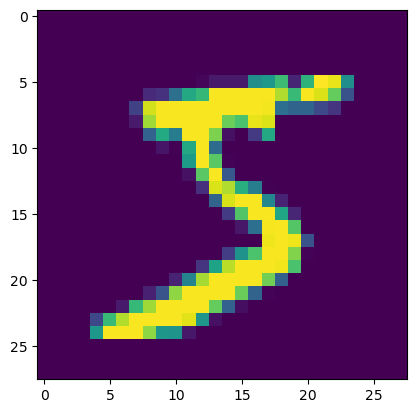

2023-03-16 19:34:49.817947: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

# Take a peek from the training set
# Seems like 60,000 images is needed for Handwriting generation
print("Shape of Training data:", train_images.shape);
print("Shape of Training Images:", train_images[0].shape);

# Peek at the data
print("Peek at data");
plt.imshow(train_images[0]);
plt.show();

# Data Params
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# The Generator

tf.keras.Sequential() => Sequential groups a linear stack of layers into a tf.keras.Model.

==============================================================================================================

model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) => Just your regular densely-connected NN layer.
<br>

Dense implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True). These are all attributes of Dense.

==============================================================================================================

In [4]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Keras Model Params:

inputs: The input(s) of the model: a keras.Input object or a combination of keras.Input objects in a dict, list or tuple.
<br>
<br>
outputs: The output(s) of the model: a tensor that originated from keras.Input objects or a combination of such tensors in a dict, list or tuple. See Functional API example below.
<br>
<br>
name: String, the name of the model.


FullArgSpec(args=[], varargs='args', varkw='kwargs', defaults=None, kwonlyargs=[], kwonlydefaults=None, annotations={})


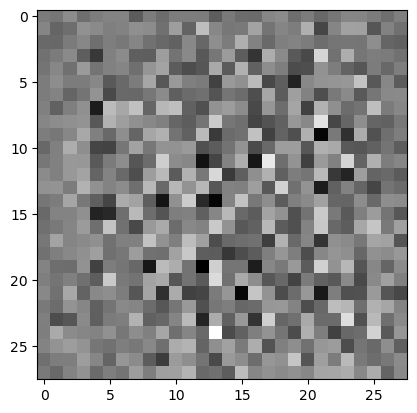

In [5]:
# Run the Untrained generator
# Untrained at this point...
generator = make_generator_model() # This instantiates the keras.Sequential Class, comes with the Model Arguements

# Lets see the params of this generator
# FullArgSpec(args=[], varargs='args', varkw='kwargs', 
# defaults=None, kwonlyargs=[], kwonlydefaults=None, annotations={})

print(inspect.getfullargspec(generator));

# Why do we need this?
noise = tf.random.normal([1, 100])

generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show();

# The Discriminator

In [6]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [8]:
# Demo test of the discrminator
# Untrained at this point...
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)


tf.Tensor([[-0.00078055]], shape=(1, 1), dtype=float32)


# Define the loss and optimizers (IMPORTANT)

In [9]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True);

In [10]:
"""
Discriminator loss:
This method quantifies how well the discriminator is able to distinguish real images from fakes. 
It compares the discriminator's predictions on real images to an array of 1s, 
and the discriminator's predictions on fake (generated) images to an array of 0s.
"""

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [11]:
"""
Generator loss:
The generator's loss quantifies how well it was able to trick the discriminator. 
Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). 
Here, compare the discriminators decisions on the generated images to an array of 1s.
"""

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output);

Since we train both models differently, we have two optimizers instead of one.

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4); # Default Learning Rate
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4); # Default Learning Rate

# Save checkpoints (Optional)

This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [13]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Training

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [14]:
# Training Parameters
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim]);

In [15]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".

# Takes the images as parameter...

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])     # Why do we need this noise??????
    
    """
    Gradient tapes use memory to store intermediate results, 
    including inputs and outputs, for use during the backwards pass. 
    For efficiency, some ops (like ReLU ) don't need to keep their intermediate results 
    and they are pruned during the forward pass.
    """
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True) # This trains the generator of creating the images

        real_output = discriminator(images, training=True) # Discriminator trains on real images to know what a real output is... 
        fake_output = discriminator(generated_images, training=True) # Discriminator trains on fake images to what a false output is...

        gen_loss = generator_loss(fake_output) # Get the Loss of the discriminator fake model
        
        # Gets the loss on how well the discriminator is able to distinguish real images from fakes. 
        # It compares the discriminator's predictions on real images to an array of 1s, 
        # and the discriminator's predictions on fake (generated) images to an array of 0s.
        disc_loss = discriminator_loss(real_output, fake_output) 

    
    # idk whats going on down here...
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [20]:
def train(dataset, epochs):
    
    # For each epoch...
    for epoch in range(epochs):
        start = time.time()
        
        # For each training step
        # For each batch in the dataset, train a step
        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
    # Generate after the final epoch
    display.clear_output(wait = True);
    generate_and_save_images(generator, epochs,seed);

# Generation or Prediction of Images

In [21]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()



# Running the Model

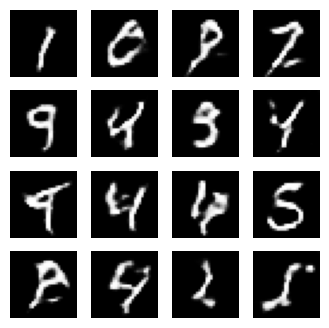

In [22]:
print("Epochs to train:", EPOCHS);
print("Train_Dataset Peek:", train_dataset);
train(train_dataset, EPOCHS)

In [ ]:
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [23]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no));

display_image(EPOCHS);